# Predict news category based on title

## Setup

In [15]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.api as sm

from IPython.display import display

sns.set(style='ticks', palette='Set2')

In [16]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [17]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [18]:
pd.set_option('display.max_columns', 9999)

## [Dataset](https://www.kaggle.com/uciml/news-aggregator-dataset)

ID : the numeric ID of the article  
TITLE : the headline of the article  
URL : the URL of the article  
PUBLISHER : the publisher of the article  
CATEGORY : the category of the news item; one of: -- b : business -- t : science and technology -- e : entertainment -- m : health  
STORY : alphanumeric ID of the news story that the article discusses  
HOSTNAME : hostname where the article was posted  
TIMESTAMP : approximate timestamp of the article's publication, given in Unix time (seconds since midnight on Jan 1, 1970)  

In [25]:
# load dataset
df=pd.read_csv('uci-news-aggregator.csv')
df.head(1)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698


In [26]:
df.tail(1)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
422418,422937,Phoenix boy undergoes surgery to repair throat...,http://www.cbs3springfield.com/story/26368078/...,WSHM-TV,m,dpcLMoJD69UYMXMxaoEFnWql9YjQM,www.cbs3springfield.com,1409229191565


In [27]:
df.shape

(422419, 8)

In [28]:
df.CATEGORY.value_counts()

e    152469
b    115967
t    108344
m     45639
Name: CATEGORY, dtype: int64

In [30]:
# encoding 'CATEGORY'
# b=0 e=1 m=2 t=3
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df['CATEGORY_ORIGINAL'] = df['CATEGORY']
df['CATEGORY'] = label_encoder.fit_transform(df['CATEGORY'])
df.head(1)

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP,CATEGORY_ORIGINAL
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,0,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698,b


## Feature and target vectors

In [252]:
X = df['TITLE'].values
y = df['CATEGORY'].values

## Vectorizing

In [249]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer(stop_words='english', max_features=20000, min_df=5)

## Model

In [248]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([ ('tfidf', TfidfTransformer()),
                      ('nb', MultinomialNB()) ])

In [250]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
X_vec = vect.fit_transform(X)

for train_index, test_index in kf.split(X_vec):
    X_train, X_test = X_vec[train_index], X_vec[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_pred_prob = pipeline.predict_proba(X_test)
    
    print('accuracy=%s logloss=%s'% (metrics.accuracy_score(y_test, y_pred), 
                                     metrics.log_loss(y_test, y_pred_prob)))

accuracy=0.860245727002 logloss=0.395624042473
accuracy=0.849983428815 logloss=0.435275837837
accuracy=0.863500781213 logloss=0.380723587991
accuracy=0.866815018228 logloss=0.380248993749
accuracy=0.850253897234 logloss=0.411530314055


In [255]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_vec = vect.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, random_state=42)

pipeline.fit(X_train_vec, y_train)

y_pred = pipeline.predict(X_test_vec)
y_pred_prob = pipeline.predict_proba(X_test_vec)

print('accuracy=%s logloss=%s'% (metrics.accuracy_score(y_test, y_pred), 
                                 metrics.log_loss(y_test, y_pred_prob)))

accuracy=0.926177737797 logloss=0.231971255242


In [257]:
from sklearn.metrics import classification_report

target_names = label_encoder.classes_

print(classification_report(y_test, y_pred_class, target_names=target_names))

             precision    recall  f1-score   support

          b       0.85      0.78      0.81     29117
          e       0.80      0.96      0.87     37988
          m       0.94      0.71      0.81     11319
          t       0.87      0.79      0.83     27181

avg / total       0.85      0.84      0.84    105605



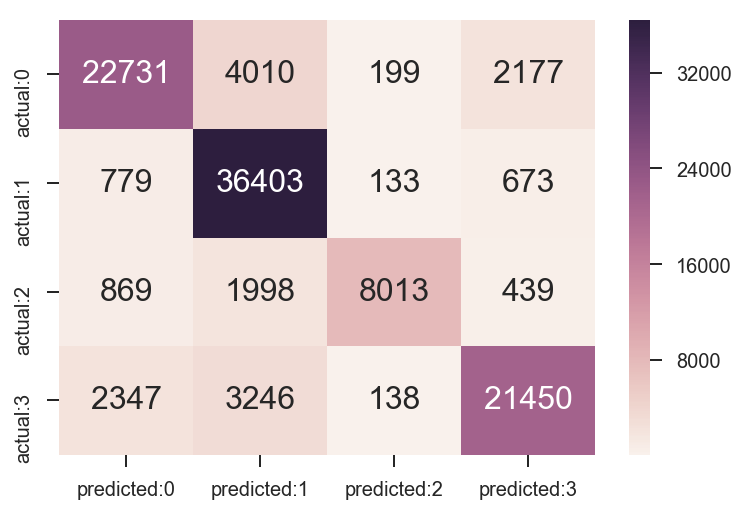

In [258]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_class)

df_cm = pd.DataFrame(cm, index=["actual:0","actual:1","actual:2","actual:3"], columns=["predicted:0","predicted:1","predicted:2","predicted:3"])
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt="d")
plt.figure(figsize = (10,7))
plt.show()

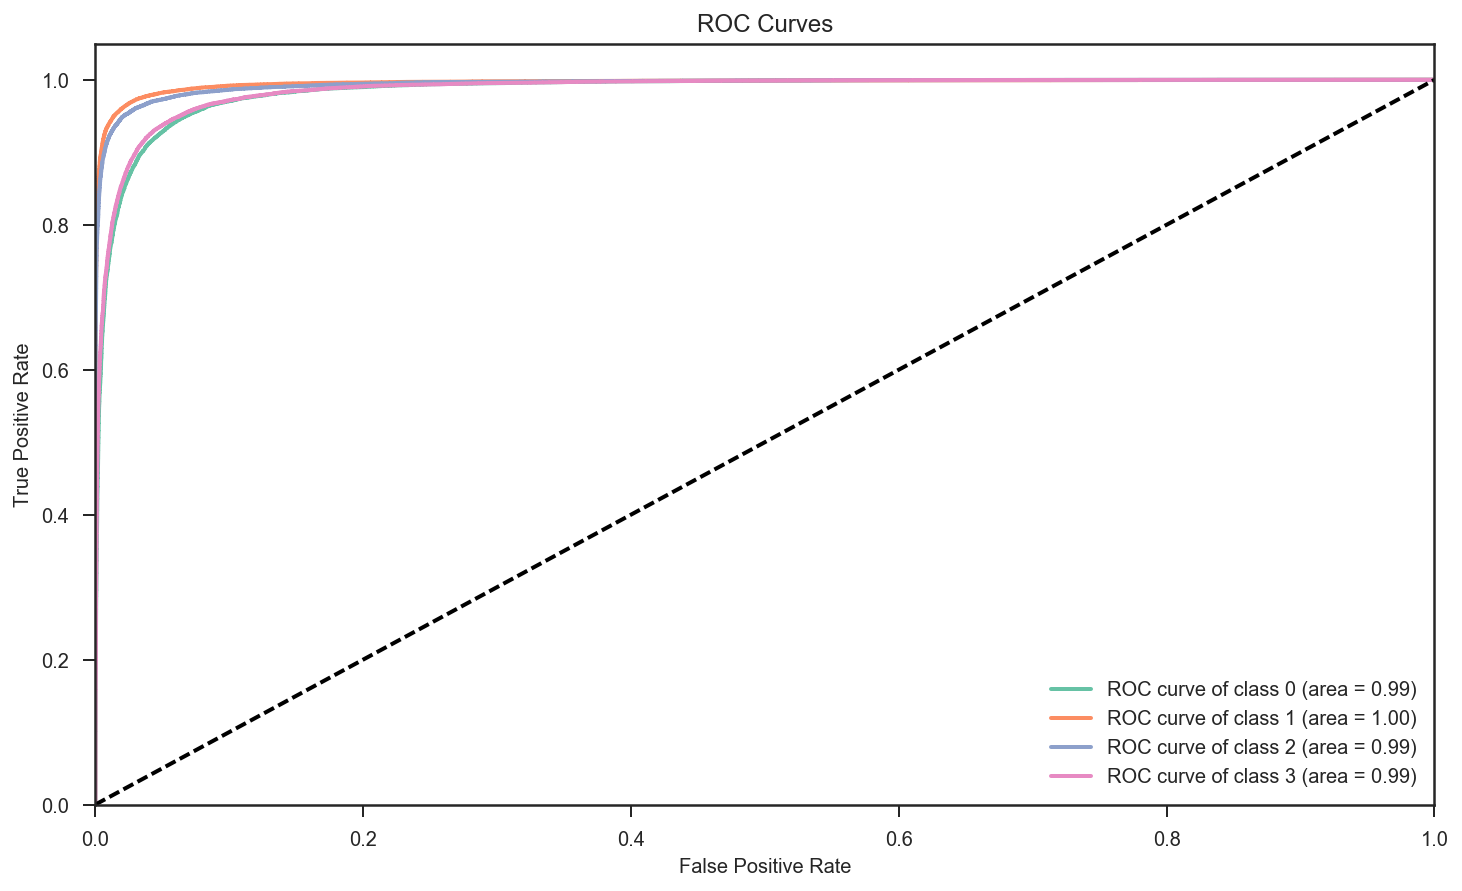

In [262]:
import scikitplot.plotters as skplt

skplt.plot_roc_curve(y_test, y_pred_prob, curves=('each_class'), figsize=(12,7))

In [243]:
def most_informative_features(vectorizer, classifier, classlabel, classindex, n=10):
    labelid = list(classifier.classes_).index(classindex)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classindex, classlabel, feat, coef)
    print()

classes_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

for lbl, idx in classes_map.items():
    most_informative_features(vect, pipeline.named_steps['nb'], lbl, idx, 5)

0 b billion -5.82073117902
0 b new -5.79080576671
0 b sales -5.76637409946
0 b china -5.54290111452
0 b stocks -5.36360621365

1 e video -5.58909547689
1 e season -5.57926663505
1 e kim -5.52349975539
1 e kardashian -5.51700959837
1 e new -5.43411243702

2 m mers -5.23829889803
2 m health -5.13812986779
2 m cancer -5.11432489662
2 m study -4.96053437669
2 m ebola -4.75477363301

3 t facebook -5.13956777981
3 t microsoft -5.0731293139
3 t samsung -4.95512051955
3 t apple -4.77579724577
3 t google -4.60770260291

